<div style="text-align:center;">
    <h1 style="font-size: 50px; margin: 0px; margin-bottom: 5px;">Hertzsprung-Russel Diagram</h1>
    <h2 style="margin:0px; margin-bottom: 5px;">COMPAS methods paper Figure 5</h2>
    <p style="text-align:center;">A notebook for reproducing the HR diagram in the COMPAS methods paper.</p>
</div>

<img src="https://compas.science/images/COMPAS_CasA.png" style="width:50%; display:block; margin:auto; margin-bottom:20px">

In [95]:
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt
import astropy.constants as consts
import astropy.units as u

In [96]:
# make the plots pretty
%config InlineBackend.figure_format = 'retina'
plt.rc('font', family='serif')
fs = 24

params = {'legend.fontsize': fs,
         'axes.labelsize': fs,
         'xtick.labelsize':0.7*fs,
         'ytick.labelsize':0.7*fs}
plt.rcParams.update(params)

# Define the stellar types
First we can make a list of objects that describe the stellar types with labels and colours

In [6]:
stellar_types = [
    None,
    {"long": "Main Sequence", "short": "MS", "colour": None},
    {"long": "Hertzsprung Gap", "short": "HG", "colour": None},
    {"long": "First Giant Branch", "short": "FGB", "colour": None},
    {"long": "Core Helium Burning", "short": "CHeB", "colour": None},
    {"long": "Early Asymptotic Giant Branch", "short": "EAGB", "colour": None},
    {"long": "Thermally Pulsing Asymptotic Giant Branch", "short": "TPAGB", "colour": None},
    {"long": "Helium Main Sequence", "short": "HeMS", "colour": None},
    {"long": "Helium Hertsprung Gap", "short": "HeHG", "colour": None},
    {"long": "Helium Giant Branch", "short": "HeGB", "colour": None},
    {"long": "Helium White Dwarf", "short": "HeWD", "colour": None},
    {"long": "Carbon/Oxygen White Dwarf", "short": "COWD", "colour": None},
    {"long": "Oxygen/Neon White Dwarf", "short": "ONeWD", "colour": None},
    {"long": "Neutron Star", "short": "NS", "colour": "grey"},
    {"long": "Black Hole", "short": "BH", "colour": "black"},
    {"long": "Massless Remnant", "short": "MR", "colour": "yellow"},
    {"long": "Chemically Homogeneous", "short": "CHE", "colour": "brown"}
]

for i in [1, 2]:
    stellar_types[i]["colour"] = plt.get_cmap("YlOrBr")(0.3 * i)

for i in [3, 4]:
    stellar_types[i]["colour"] = plt.get_cmap("Blues")(0.3 * (i - 2))

for i in [5, 6]:
    stellar_types[i]["colour"] = plt.get_cmap("Greens")(0.3 * (3 - (i - 4)))
    
for i in [7, 8, 9]:
    stellar_types[i]["colour"] = plt.get_cmap("plasma")(0.1 + 0.2 * (i - 7))
    
for i in [10, 11, 12]:
    stellar_types[i]["colour"] = plt.get_cmap("copper")(0.1 + 0.2 * (i - 9))

# Helpful functions
Some quick and useful functions here that find the LBV limit that COMPAS uses, get variables from a COMPAS detailed output file and convert temperature and luminosity to radius.

In [97]:
def LBV_limit(T_eff):
    """ Compute the luminosity of the LBV limit given a certain temperature """
    return np.maximum(np.sqrt(1e10 * u.Rsun**2 * u.Lsun * (4 * np.pi * consts.sigma_sb * (T_eff * u.K)**4)).to(u.Lsun), np.repeat(6e5 * u.Lsun, len(T_eff)))

In [22]:
def get_detailed_output_vars(compas_file, variables):
    """ Return a list of variables from a COMPAS detailed output file """
    with h5.File(compas_file, "r") as compas:
        var_list = [compas[variables[i]][...].squeeze() for i in range(len(variables))]
    return var_list

# Plotting function
This function will create a Hertzsprung-Russel diagram from COMPAS output of effectively single stars for a range of masses. You can specify:

- The exact stars to plot
- Whether to use lines or scatter points
- Where to put the mass labels
- The range of stellar types to plot
- Whether to include labels for the stellar types
- Whether to shade the LBV regime and where to place the annotation
- Whether to plot lines of constant radii

Check out the docstring in the function to try this out

In [100]:
def plot_HRD(folder_name, file_numbers,
             fig=None, ax=None, show=True,
             lines=True, label_loc="start", max_ev_time=13700.0,
             stellar_type_range=range(1, 13), stellar_type_list=True,
             LBV_regime=True, LBV_loc=(0.77, 0.93), plot_R_lines=True):
    """Plot a Hertzsprung-Russel diagram from COMPAS Output

    Parameters
    ----------
    folder_name : `string`
        The name of the folder containing the COMPAS output
    
    file_numbers : `array of ints`
        Which individual detailed output files to plot
    
    fig : `figure`, optional
        Matplotlib figure to, by default None
    
    ax : `axis`, optional
        Matplotlib axis to use, by default None
    
    show : `bool`, optional
        Whether to immediately show the plot or just return it, by default True
    
    lines : `bool`, optional
        Whether to use lines or scatter points, by default True
    
    label_loc : `'start' or 'end'`, optional
        Location of mass labels ("), by default "start"
    
    max_ev_time : `float`, optional
        The maximum evolution time of the star to plot, by default 13700.0
    
    stellar_type_range : `array of ints`, optional
        Which stellar types to plot, by default range(1, 13)
    
    stellar_type_list : `bool`, optional
        Whether to include an annotation of the list of stellar types, by default True
    
    LBV_regime : `bool`, optional
        Whether to shade the LBV regime, by default True
    
    LBV_loc : `tuple`, optional
        Location of LBV regime annotation (ignored if ``LBV_regime`` is False), by default (0.77, 0.93)
    
    plot_R_lines : `bool`, optional
        Whether to plot lines of constant radii, by default True
    """
    
    # if either figure or axis is not provided, create a new one
    if fig is None or ax is None:
        fig, ax = plt.subplots(1, figsize=(10, 14))

    # go through each detailed output file
    for file in file_numbers:
        # get variables from output file
        file_path = folder_name + "/Detailed_Output/BSE_Detailed_Output_{}.h5".format(file)
        time, T_eff, L, stellar_type, Z, m_1 = get_detailed_output_vars(file_path, variables=["Time",
                                                                                              "Teff(1)",
                                                                                              "Luminosity(1)",
                                                                                              "Stellar_Type(1)",
                                                                                              "Metallicity@ZAMS(1)",
                                                                                              "Mass(1)"])
        
        # mask items past the maximum evolution time
        time_limit = time <= max_ev_time
        log_T_eff = np.log10(T_eff[time_limit])
        log_L = np.log10(L[time_limit])
        stellar_type = stellar_type[time_limit]
        
        # combine main sequence stellar types for convenience
        stellar_type[stellar_type == 0] = 1
        
        # annotate each track with its mass
        if label_loc == "start":
            ax.annotate("{0:1.1f}".format(m_1[0]) + r"${\rm M_\odot}$ ", (log_T_eff[np.isin(stellar_type, stellar_type_range)][0],
                                                                          log_L[np.isin(stellar_type, stellar_type_range)][0]),
                        ha="right", va="center", fontsize=fs*0.7, zorder=6, bbox=dict(fc="w", ec="w", alpha=0.5, boxstyle="round,pad=0."))
        elif label_loc == "end":
            ax.annotate("{0:1.1f}".format(m_1[0]) + r"${\rm M_\odot}$ ", (log_T_eff[np.isin(stellar_type, stellar_type_range)][-1], 
                                                                          log_L[np.isin(stellar_type, stellar_type_range)][-1]),
                        ha="right", va="center", fontsize=fs*0.7)

        # go through each of the given stellar types
        reaches_WD = False
        for st in stellar_type_range:
            # get all matching points
            type_mask = stellar_type == st
            
            # if they are none of this stellar type then keep going
            if len(log_T_eff[type_mask]) == 0:
                continue
            
            # avoid plotting WD cooling tracks
            if st in [10, 11, 12]:
                # mark the star as having reached WD and plot only a single point
                reaches_WD = True
                ax.scatter(log_T_eff[type_mask][0], log_L[type_mask][0], s=10, color=stellar_types[st]["colour"], zorder=5)
            else:
                # if user doesn't want lines or very low number of timesteps use scatter points
                if not lines or len(log_T_eff[type_mask]) <= 1:
                    ax.scatter(log_T_eff[type_mask], log_L[type_mask], s=5, color=stellar_types[st]["colour"], zorder=5)

                # otherwise just plot a line
                else:
                    ax.plot(log_T_eff[type_mask], log_L[type_mask], color=stellar_types[st]["colour"], lw=2)
        
        # plot a point at the end of the track if it doesn't reach WD
        if not reaches_WD:
            final_mask = np.isin(stellar_type, stellar_type_range)
            ax.scatter(log_T_eff[final_mask][-1], log_L[final_mask][-1], s=10,
                       color=stellar_types[stellar_type[final_mask][-1]]["colour"], zorder=5)
     
    # annotate the plot with the metallicity
    ax.annotate(r"$Z = {0}$".format(np.round(Z[0], 4)), xy=(0.02, 0.98),
                xycoords="axes fraction", color="black", fontsize=fs*0.7, va="top")
    
    # annotate plot with labels for stellar types
    if stellar_type_list:
        for i, st in enumerate(stellar_type_range):
            ax.annotate(stellar_types[st]["short"], xy=(0.02, 0.03 * (len(stellar_type_range) - 0.5 - i)),
                        xycoords="axes fraction", color=stellar_types[st]["colour"], fontsize=0.7*fs, weight="bold")

    # set the axis labels
    ax.set_xlabel(r"$\log_{10} \left(T_{\rm eff} / \mathrm{K} \right)$")
    ax.set_ylabel(r"$\log_{10} \left(L / \mathrm{L_\odot} \right)$")

    # slightly adjust xlims and save original limits
    xlims = list(reversed(ax.get_xlim()))
    ax.set_xlim(xlims[0], 3.2)
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    
    # if the user wants some constant radii in the background
    if plot_R_lines:
        # create a range of temperatures and luminosities (and use Astropy units)
        T_eff = np.logspace(xlims[0], xlims[1], 1000) * u.K
        Lum = np.logspace(-2, 8, 1000) * u.Lsun
        
        # turn these into a grid
        L, T = np.meshgrid(Lum, T_eff)
        
        # compute the radius for this grid and convert to solar radii
        R = np.sqrt(L / (4 * np.pi * consts.sigma_sb * T**4)).to(u.Rsun)
        
        # make a contour plot of these values
        cont = ax.contour(np.log10(T_eff.value), np.log10(Lum.value), np.log10(R.to(u.Rsun).value),
                          levels=[-3, -2, -1, 0, 1, 2, 3], colors="grey", zorder=1, linewidths=0.5, linestyles="dotted")
        
        # format the labels nicely with solar radii
        def fmt(x):
            if x < 0:
                return "{}".format(10**(x)) + r"$\,{\rm R_{\odot}}$"
            else:
                return "{}".format(int(np.round(10**(x)))) + r"$\,{\rm R_{\odot}}$"
            
        # manually place the labels for the original plot (leave it auto otherwise)
        if stellar_type_range == range(1, 13):
            manual = [(5, -1.5), (4.5, -1), (4.0, -0.5), (3.5, -0.5), (3.3, 1.0), (3.3, 2.5), (3.3, 4.5)]
        else:
            manual = None
            
        # label the lines
        ax.clabel(cont, fmt=fmt, use_clabeltext=True, rightside_up=False, manual=manual, fontsize=0.5*fs)
    
    # if the user wants to shade the LBV regime
    if LBV_regime:
        # make some fairly reasonable temperature range
        T_eff_range = np.logspace(3, 6, 1000)
        
        # plot a line at the HD limit and fill the area
        ax.plot(np.log10(T_eff_range), np.log10(LBV_limit(T_eff_range).value), color="grey", linestyle="dotted")
        ax.fill_between(np.log10(T_eff_range), np.log10(LBV_limit(T_eff_range).value), 9, color="black", lw=2, alpha=0.03)
        
        # annotate the regime with a custom location
        ax.annotate("LBV Regime", xy=LBV_loc, xycoords="axes fraction", ha="center", va="center", fontsize=fs*0.7, color="grey", zorder=10)

    # reset the x and y limits in case they changed
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)

    # show the figure if they want it
    if show:
        plt.show()
        
    # return created figure
    return fig, ax

# Recreate the figure from the paper
Run the following cell to recreate the figure from the paper

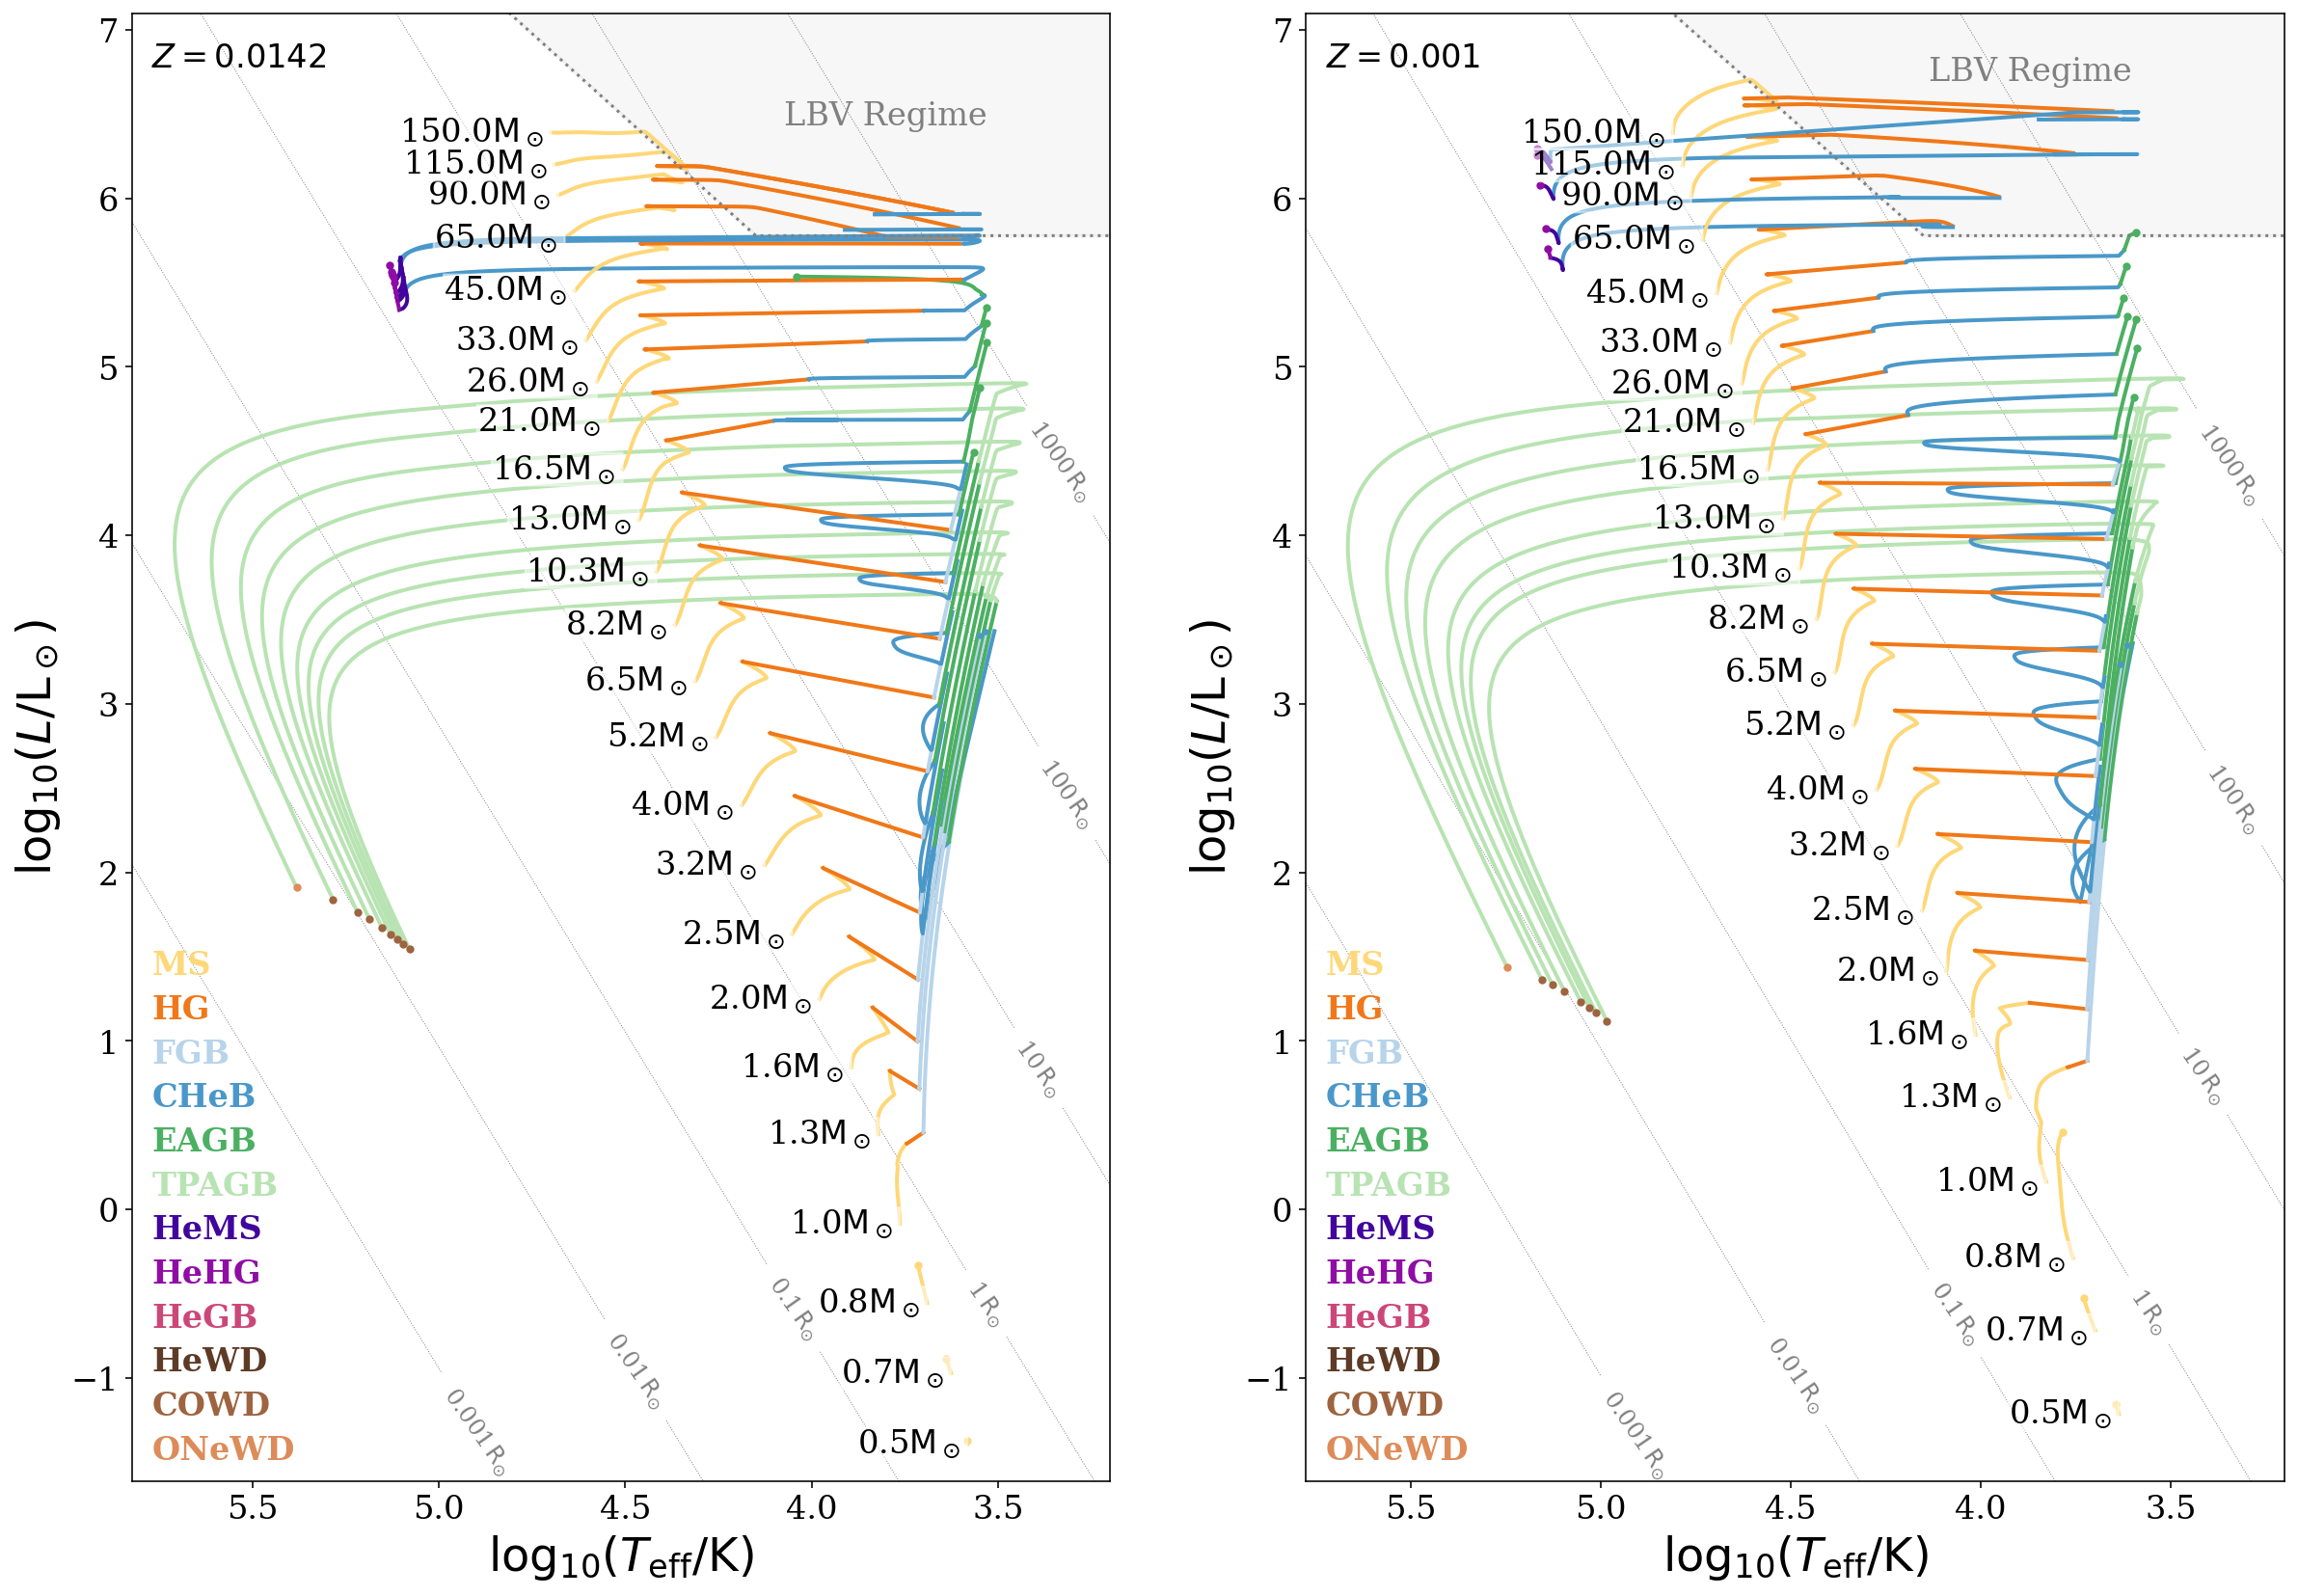

In [102]:
fig, ax = plt.subplots(1, 2, figsize=(20, 14))
plot_HRD("COMPAS_Output", range(24), fig=fig, ax=ax[0], show=False)
plot_HRD("COMPAS_Output", range(24, 48), LBV_loc=(0.74, 0.96), fig=fig, ax=ax[1], show=False)

ylims = (max(ax[0].get_ylim()[0], ax[1].get_ylim()[0]), max(ax[0].get_ylim()[1], ax[1].get_ylim()[1]))

for ax_thing in ax.flatten():
    ax_thing.set_ylim(ylims)
    ax_thing.set_yticks([-1, 0, 1, 2, 3, 4, 5, 6, 7])
    
plt.savefig("hrd.pdf", format="pdf", bbox_inches="tight")

plt.show()